### Computer Specs

Operating System: OS X

Computer: 2018 MacBook Pro (16G ram)

### Notebook Structure

The solutions to each question was positioned after the code that was used to find the answer. These answers can be found in a markdown cell.

Please see the HTML version of this notebook: capone-challenge-kotwani.html

### Thank You

Thank you for giving me the opportunity to complete this challenge. I have learned a lot by completing this assessment. I am aware there are many great scientists and engineers out there. I hope this work helps me build my case for why I can learn and adapt to new technologies and situations.

### Question 1: Load

Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found here
Please describe the structure of the data. Number of records and fields in each record?
Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

### Question 2: Plot

Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
Report any structure you find and any hypotheses you have about that structure.

### Question 3: Data Wrangling - Duplicate Transactions

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

Can you programmatically identify reversed and multi-swipe transactions?
What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
Did you find anything interesting about either kind of transaction?

### Question 4: Model

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
Provide an estimate of performance using an appropriate sample, and show your work.
Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

In [1]:
import os
import utils
import json
import numpy as np
import pandas as pd
import catboost

import matplotlib.pyplot as plt
from scipy.stats import expon

import re 
import datetime

from sklearn import model_selection

#utils.py contains helper functions
import importlib
importlib.reload(utils)


fname = "transactions.txt"

"""
The file seems to have some problem when loading is as a json file.

The error occurs at line 2, column 1

There are 600MB in this file
"""

try:
    data=json.load(open(fname,'r'))
except Exception as e: print(e)
    
    
print('File size:',utils.get_file_size(fname))

Extra data: line 2 column 1 (char 760)
File size: 609937737


In [105]:
"""
It seems the file contains a list of dictionaries.

We need to read it line by line.
"""

data_file = open(fname, "r") 

line =  data_file.readline()
line


'{"accountNumber": "737265056", "customerId": "737265056", "creditLimit": 5000.0, "availableMoney": 5000.0, "transactionDateTime": "2016-08-13T14:27:32", "transactionAmount": 98.55, "merchantName": "Uber", "acqCountry": "US", "merchantCountryCode": "US", "posEntryMode": "02", "posConditionCode": "01", "merchantCategoryCode": "rideshare", "currentExpDate": "06/2023", "accountOpenDate": "2015-03-14", "dateOfLastAddressChange": "2015-03-14", "cardCVV": "414", "enteredCVV": "414", "cardLast4Digits": "1803", "transactionType": "PURCHASE", "echoBuffer": "", "currentBalance": 0.0, "merchantCity": "", "merchantState": "", "merchantZip": "", "cardPresent": false, "posOnPremises": "", "recurringAuthInd": "", "expirationDateKeyInMatch": false, "isFraud": false}\n'

In [92]:
data_file = open(fname, "r") 
data = data_file.readlines()

In [93]:
def convert_df(x):
    dctnry = json.loads(x)
    dctnry = {k:[v] for k,v in dctnry.items()}
    return pd.DataFrame(dctnry)

data = list(map(lambda x: convert_df(x), data))

In [2]:
import gc
gc.collect()

31

In [100]:
"""
Now the dataframe is built
"""
df = pd.concat(data, sort=True,axis=0)

In [101]:
df.to_pickle('df.pkl')

In [429]:
df = pd.read_pickle('df.pkl')

In [ ]:
"""
The data looks like it loaded correctly
"""
df.head()

In [102]:
del data

In [430]:
"""
There are 786K rows and 29 columns:

"""
df.shape 

(786363, 29)

In [431]:

"""
There are a few columns labelled as objects. Further inspection is required to determine their types.

accountNumber
accountOpenDate
acqCountry
availableMoney (float)
cardCVV
cardLast4Digits
cardPresent (bool)
creditLimit (float)
currentBalance (float)
currentExpDate
customerId
dateOfLastAddressChange
echoBuffer
enteredCVV
expirationDateKeyInMatch (bool)
isFraud (target) (bool)
merchantCategoryCode
merchantCity
merchantCountryCode
merchantName
merchantState
merchantZip
posConditionCode
posEntryMode
posOnPremises
recurringAuthInd
transactionAmount (float)
transactionDateTime
transactionType

"""

print('unique types',df.dtypes.unique(),'\n')
print('BOOL',df.columns[df.dtypes==np.bool],'\n')
print('FLOAT',df.columns[df.dtypes==np.float64],'\n')
print('OBJECT',df.columns[df.dtypes==object],'\n')

unique types [dtype('O') dtype('float64') dtype('bool')] 

BOOL Index(['cardPresent', 'expirationDateKeyInMatch', 'isFraud'], dtype='object') 

FLOAT Index(['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount'], dtype='object') 

OBJECT Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'cardCVV',
       'cardLast4Digits', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'merchantCategoryCode', 'merchantCity', 'merchantCountryCode',
       'merchantName', 'merchantState', 'merchantZip', 'posConditionCode',
       'posEntryMode', 'posOnPremises', 'recurringAuthInd',
       'transactionDateTime', 'transactionType'],
      dtype='object') 



### Column Inspection

The dataframe was able to infer the following data types:

1. isFraud (boolean)
2. cardPresent (boolean)
3. expirationDateKeyInMatch (boolean) 
4. availableMoney (float)
5. creditLimit (float)
6. currentBalance (float)
7. transactionAmount (float)



There are a few columns labelled as objects. Further inspection is require to determine the data types for these columns. The following analysis is used to logically reduce the set of data types.

1. accountNumber (id)
2. accountOpenDate (date)
3. acqCountry (cat)
4. cardCVV (int) (id)
5. cardLast4Digits (int) (id)
6. currentExpDate (date)
7. customerId (id)
8. dateOfLastAddressChange (date)
9. echoBuffer (?)
10. enteredCVV (int) (id) **potentially a useful attribute
11. merchantCategoryCode (cat)
12. merchantCity (cat)
13. merchantCountryCode (cat)
14. merchantName (id) (cat)
15. merchantState (cat)
16. merchantZip (cat)
17. posConditionCode (cat)
18. posEntryMode (cat)
19. posOnPremises (?)
20. recurringAuthInd (bool?)
21. transactionDateTime (datetime)
22. transactionType (cat)


In [432]:
"""
There are a few columns with only one value, i.e., echoBuffer, merchantCity, merchantState, merchantZip,
posOnPremises,recurringAuthInd.
"""
df.nunique()

accountNumber                 5000
accountOpenDate               1820
acqCountry                       5
availableMoney              521916
cardCVV                        899
cardLast4Digits               5246
cardPresent                      2
creditLimit                     10
currentBalance              487318
currentExpDate                 165
customerId                    5000
dateOfLastAddressChange       2184
echoBuffer                       1
enteredCVV                     976
expirationDateKeyInMatch         2
isFraud                          2
merchantCategoryCode            19
merchantCity                     1
merchantCountryCode              5
merchantName                  2490
merchantState                    1
merchantZip                      1
posConditionCode                 4
posEntryMode                     6
posOnPremises                    1
recurringAuthInd                 1
transactionAmount            66038
transactionDateTime         776637
transactionType     

### Unique Value Counts

There appears to be a total of 5000 customers and 2490 merchant names in the dataset. There are 5246 unique last4digits in the datset which is more than the number of customers. 

Interestingly, there are fewer transaction datetimes than the number of records. What are the changes of that if the transactions are down to the second values?

In [433]:
print(df.echoBuffer.unique())
print(df.merchantZip.unique())
print(df.merchantCity.unique())
print(df.posOnPremises.unique())
print(df.recurringAuthInd.unique())

"""
These columns will be dropped from the dataset due to being empty
"""

df.drop(['echoBuffer','merchantZip','merchantCity','merchantState',
         'posOnPremises','recurringAuthInd'],axis=1,inplace=True)

['']
['']
['']
['']
['']


In [434]:
"""
The percentage of postives, 1.5%, in the dataset is higher than expected. 

It is possible that the dataset does not represent a random sample. 

It is possible that stratified sampling was applied to the dataset.

"""

target = ['isFraud']

print('unique values',df['isFraud'].unique())

print('percentage of positives',df['isFraud'].mean())

unique values [False  True]
percentage of positives 0.01579041740264992


In [435]:
"""
Maybe create a time differenced variable here for balaced owed.

Do frequent small transaction represent more or less risk?

percent of credit not used (credit limit-available money)/(credit limit)

"""

numerics = [
'cardPresent',
'expirationDateKeyInMatch',
'availableMoney',
'creditLimit',
'currentBalance',
'transactionAmount']

for col in numerics:
    val_counts = df[col].value_counts()
    most_common = val_counts.index[0]
    most_common_cnt = val_counts.values[0]
    print('column name',col)
    print('most common',most_common)
    print('most common count',most_common_cnt)
    print('most common percent',most_common_cnt/df.shape[0])
    print('maximum',df[col].max())
    print('minimum',df[col].min())
    print()

column name cardPresent
most common False
most common count 433495
most common percent 0.5512657640300981
maximum True
minimum False

column name expirationDateKeyInMatch
most common False
most common count 785320
most common percent 0.9986736405451426
maximum True
minimum False

column name availableMoney
most common 250.0
most common count 6015
most common percent 0.007649139138031672
maximum 50000.0
minimum -1005.63

column name creditLimit
most common 5000.0
most common count 201863
most common percent 0.25670460080141105
maximum 50000.0
minimum 250.0

column name currentBalance
most common 0.0
most common count 33678
most common percent 0.04282754910899928
maximum 47498.81
minimum 0.0

column name transactionAmount
most common 0.0
most common count 22225
most common percent 0.028263028652161914
maximum 2011.54
minimum 0.0



In [436]:
"""
There seems to be an address change date for each customer. 

If the customer, stops going to the exact places as before, could it be due to an address change?

Did the transaction happen after the expiration?
"""

datecols = ['accountOpenDate',
'currentExpDate',
'dateOfLastAddressChange',
'transactionDateTime']

for col in datecols:
    print(col)
    print(df[col].unique()[:10])
    print()
    
"""
'%Y-%m-%d'
'%m/%Y'
'%Y-%m-%d'
'%Y-%m-%dT%H:%M:%S'
"""

accountOpenDate
['2015-03-14' '2015-08-06' '2015-10-13' '2014-07-25' '2015-07-27'
 '2015-12-19' '2014-11-15' '2015-08-12' '2014-02-15' '2013-01-29']

currentExpDate
['06/2023' '02/2024' '08/2025' '10/2029' '01/2020' '05/2020' '01/2021'
 '08/2032' '04/2020' '05/2023']

dateOfLastAddressChange
['2015-03-14' '2015-08-06' '2015-10-13' '2014-07-25' '2015-07-27'
 '2016-03-26' '2016-05-03' '2016-05-05' '2016-06-25' '2016-10-19']

transactionDateTime
['2016-08-13T14:27:32' '2016-10-11T05:05:54' '2016-11-08T09:18:39'
 '2016-12-10T02:14:50' '2016-03-24T21:04:46' '2016-04-19T16:24:27'
 '2016-05-21T14:50:35' '2016-06-03T00:31:21' '2016-06-10T01:21:46'
 '2016-07-11T10:47:16']



"\n'%Y-%m-%d'\n'%m/%Y'\n'%Y-%m-%d'\n'%Y-%m-%dT%H:%M:%S'\n"

In [437]:
"""
Most of the cards in the dataset were acquired in the US.

Most of the merchant transaction also happen in the US.

Are there some customer charateristic that describes who is likely to use their card abroad?

How often does the merchant name match the merchant name from a previous transaction?

"""

categoricals = [
'acqCountry',
'merchantCategoryCode',
'merchantCountryCode',
'merchantName',
'posConditionCode',
'posEntryMode',
'transactionType']

for col in categoricals:
    val_counts = df[col].value_counts()
    most_common = val_counts.index[0]
    most_common_cnt = val_counts.values[0]
    print('column name',col)
    print('sample values',df[col].unique()[:10])
    print('most common',most_common)
    print('most common count',most_common_cnt)
    print('most common percent',most_common_cnt/df.shape[0])
    print()

column name acqCountry
sample values ['US' '' 'CAN' 'MEX' 'PR']
most common US
most common count 774709
most common percent 0.9851798723998968

column name merchantCategoryCode
sample values ['rideshare' 'entertainment' 'mobileapps' 'fastfood' 'food_delivery'
 'auto' 'online_retail' 'gym' 'health' 'personal care']
most common online_retail
most common count 202156
most common percent 0.2570772022590076

column name merchantCountryCode
sample values ['US' 'CAN' '' 'PR' 'MEX']
most common US
most common count 778511
most common percent 0.9900147896073442

column name merchantName
sample values ['Uber' 'AMC #191138' 'Play Store' 'Tim Hortons #947751'
 'In-N-Out #422833' 'Krispy Kreme #685312' 'Shake Shack #968081'
 'Burger King #486122' 'Five Guys #510989' "Auntie Anne's #747964"]
most common Uber
most common count 25613
most common percent 0.0325714714451214

column name posConditionCode
sample values ['01' '08' '99' '']
most common 01
most common count 628787
most common percent 0.79961

In [438]:
df[df.posConditionCode!='01'].isFraud.mean()

0.013879017109204448

In [439]:

"""
It seems that accountNumber represents the same information as customerId.

There could be multiple people associated with an account, and the lst 4 digit could be useful to find this.

Is it possible for a card on an account to be replaced with another over time?

There are numbers are attached to the merchant name, are these store numbers?

Does the enteredCVV match the card CVV, how big was the error (edit distance)?

Should fraud cases be based on transactions, individuals, cards. Should seperate models be built?
What the the correct train-validation dataset construction for each case?

"""

idcols = ['accountNumber',
'cardCVV',
'cardLast4Digits',
'customerId',
'enteredCVV',
'merchantName']

for col in idcols:
    val_counts = df[col].value_counts()
    most_common = val_counts.index[0]
    most_common_cnt = val_counts.values[0]
    print('column name',col)
    print('sample values',df[col].unique()[:10])
    print('most common',most_common)
    print('most common count',most_common_cnt)
    print('most common percent',most_common_cnt/df.shape[0])
    print()

column name accountNumber
sample values ['737265056' '830329091' '574788567' '924729945' '984504651' '114896048'
 '482277829' '239577603' '863358589' '711536931']
most common 380680241
most common count 32850
most common percent 0.04177460028002335

column name cardCVV
sample values ['414' '486' '885' '206' '579' '205' '640' '773' '483' '438']
most common 869
most common count 33749
most common percent 0.04291783819940664

column name cardLast4Digits
sample values ['1803' '767' '3143' '8522' '4219' '9459' '8332' '8915' '7507' '7468']
most common 593
most common count 32946
most common percent 0.04189668130367273

column name customerId
sample values ['737265056' '830329091' '574788567' '924729945' '984504651' '114896048'
 '482277829' '239577603' '863358589' '711536931']
most common 380680241
most common count 32850
most common percent 0.04177460028002335

column name enteredCVV
sample values ['414' '486' '885' '206' '579' '539' '205' '265' '640' '670']
most common 869
most common count

In [440]:
#balance is the amount owed.. maybe create a time differenced variable here
#given that there are many uber transaction, could the sample set me biased toward uber?
#do small transactions represent more risk?
#customerIds represent accounts, how to find whether there are multiple people to an account (card numbers)
#should fraud cases be based on individuals or cards (how to consider both perspectives)
#does the enteredCVV match the card CVV, how big was the error?

In [441]:
"""
We will replace '' with null to count the true missing values
"""
df.replace({'':np.nan}).isnull().sum(axis=0)

accountNumber                  0
accountOpenDate                0
acqCountry                  4562
availableMoney                 0
cardCVV                        0
cardLast4Digits                0
cardPresent                    0
creditLimit                    0
currentBalance                 0
currentExpDate                 0
customerId                     0
dateOfLastAddressChange        0
enteredCVV                     0
expirationDateKeyInMatch       0
isFraud                        0
merchantCategoryCode           0
merchantCountryCode          724
merchantName                   0
posConditionCode             409
posEntryMode                4054
transactionAmount              0
transactionDateTime            0
transactionType              698
dtype: int64

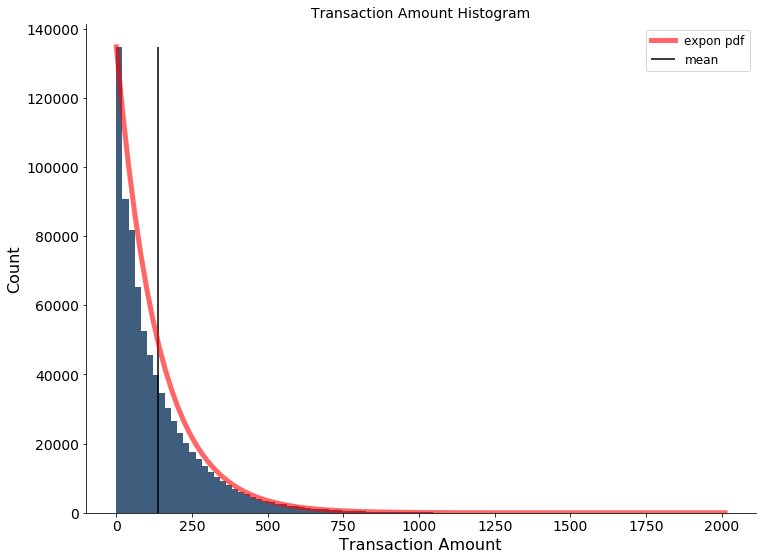

In [442]:
"""
A scaled exponential distribution with the mean of the data element is ploted with the histogram.

Initially, it seemed that the distribution did not fit perfectly.
"""

plt.figure(figsize=(12, 9))  
  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title("Transaction Amount Histogram", fontsize=14)  

plt.xlabel("Transaction Amount", fontsize=16)  
plt.ylabel("Count", fontsize=16)  

pkg = plt.hist(df.transactionAmount,  
         color="#3F5D7D", bins=100)  


mean_value = df.transactionAmount.mean()
plt.vlines(mean_value,0,np.max(pkg[0]),label='mean')

ax.plot(pkg[1],np.exp(-1/mean_value*pkg[1])*np.max(pkg[0]),
       'r-', lw=5, alpha=0.6, label='expon pdf')

plt.legend( prop={'size': 12})
plt.show()

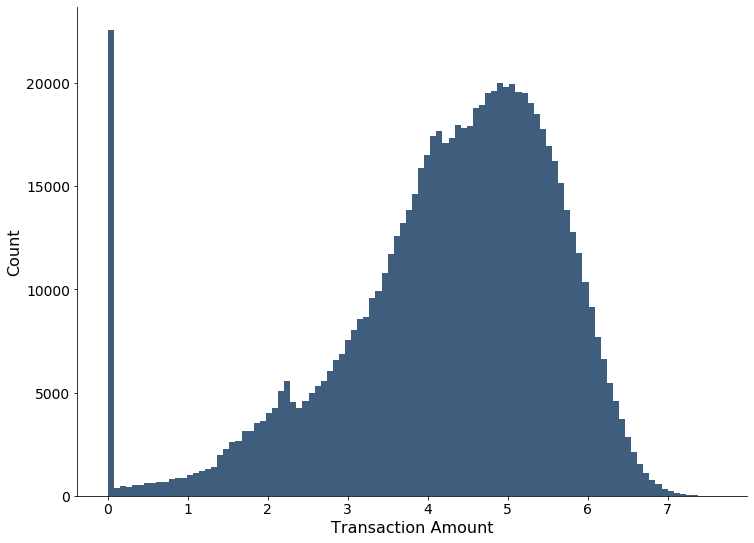

In [443]:
"""
The plot of the histgoram for log(transaction amount +1) confirms that initially suspicion.

There are many transaction amounts with a value of zero.
"""

plt.figure(figsize=(12, 9))  
  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
  
plt.xlabel("Transaction Amount", fontsize=16)  
plt.ylabel("Count", fontsize=16)  
  
plt.hist(np.log(df.transactionAmount+1),  
         color="#3F5D7D", bins=100)  
plt.show()

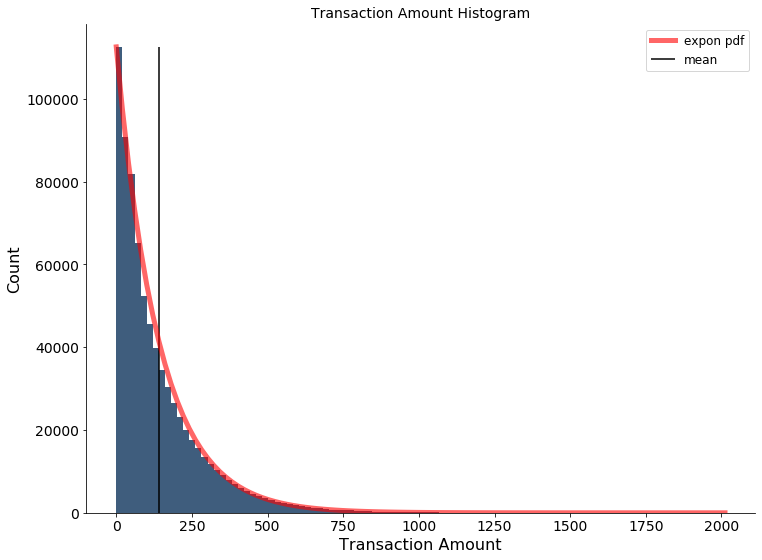

In [444]:
"""
When the zero element are excluded, the distribution fit much better.
"""

plt.figure(figsize=(12, 9))  
  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title("Transaction Amount Histogram", fontsize=14)  

plt.xlabel("Transaction Amount", fontsize=16)  
plt.ylabel("Count", fontsize=16)  

pkg = plt.hist(df[df.transactionAmount>0].transactionAmount,  
         color="#3F5D7D", bins=100)  


mean_value = df[df.transactionAmount>0].transactionAmount.mean()
plt.vlines(mean_value,0,np.max(pkg[0]),label='mean')

ax.plot(pkg[1],np.exp(-1/mean_value*pkg[1])*np.max(pkg[0]),
       'r-', lw=5, alpha=0.6, label='expon pdf')

plt.legend(prop={'size': 12})
plt.show()

### Transaction Amount

The structure of the transaction amount data element seems to follow a negative exponential distribution. The mean value is somewhere around $150 dollars. 

After further inspection and by using a logorithmic transformation it can be seen that there are a large number of transaction with a value of 0. These might be psuedo transactions which are not related to purchases. 

In the larger context of the problem, there could be an adverserial strategy that uses these transaction to determin the viability of fraud. A seperate indicator could be created for these cases. After removing the zero values from the plot, it can be seen that the distribution follows the exponential distribution more closely. 

In the context of building a model, taking the log transformation might be useful for building a predictive model. It minimizes the effect of outliers. A seperate feature could be create to indicate large or anomalous values.

If I has more time, I plot the various categorical variables for when the transaction value was zero. For example, a bar plot of tranaction type could be created for when this is condition.

In [559]:
"""
The dataset contains duplicate transaction datetimes. These might indicate multi-swipe transactions.

However, the transaction are on the seconds time level so edge cases are possible.

The datetime columns can be converted to the correct data type for further inspection.

"""

datecols = ['accountOpenDate',
'currentExpDate',
'dateOfLastAddressChange',
'transactionDateTime']

    
dateformats = ['%Y-%m-%d',
'%m/%Y',
'%Y-%m-%d',
'%Y-%m-%dT%H:%M:%S']
            

for col,form in zip(datecols,dateformats):
    try:
        print('converting',col,form)
        df[col]=df[col].apply(lambda x: datetime.datetime.strptime(x,form))
    except Exception as e:
        print(col,e)


converting accountOpenDate %Y-%m-%d
accountOpenDate strptime() argument 1 must be str, not Timestamp
converting currentExpDate %m/%Y
currentExpDate strptime() argument 1 must be str, not Timestamp
converting dateOfLastAddressChange %Y-%m-%d
dateOfLastAddressChange strptime() argument 1 must be str, not Timestamp
converting transactionDateTime %Y-%m-%dT%H:%M:%S
transactionDateTime strptime() argument 1 must be str, not Timestamp


In [447]:
"""
Here we confirm that all customer ids are exactly the same as the account numbers
"""
(df.customerId==df.accountNumber).sum()==df.shape[0]

True

In [448]:
"""
We will create a transactionId to mitigate the possibility of multiple people using the same account.

Here are potentially two ways to create the transactionID: 1) customerId+merchantName, 2) customerId+last4Digits

In case 2) we have the possibility of multiple people using the card for online and in-store purchases. 

Since the goal is to find multi-swipes, option 1) will be used because the problem state it happens 
on accident.

"""


createTransactionId = lambda x: str(x['customerId'])+'_'+str(x['merchantName'])

df['transactionId'] = df[['customerId','merchantName']].apply(createTransactionId,axis=1)


"""
A row id is added to identify unique records.
"""
df['rowId'] = np.arange(0,df.shape[0])

In [449]:
"""
How likely is it that in a population of 5K people that two transactions happen at the exact same time
with two different people?

It seems that in 9609 out of the 9726 of the cases where there was a duplicate transaction datetime,
there were different customers. Only 117 cases had different 
"""

unique_transaction_dttm = df.transactionDateTime.nunique()
total_transactions = df.shape[0]
duplicate_transaction_dttm = total_transactions-unique_transaction_dttm
print('duplicate transaction datetimes',duplicate_transaction_dttm)

unq_trns_dttm = df[['customerId',
                    'transactionDateTime']].groupby('transactionDateTime').agg(utils.pandas_agg_cnt_unqs)    

sm_dttm_diff_cust = unq_trns_dttm[unq_trns_dttm.customerId>1].shape[0]

print('duplicate transaction datetimes with different customer ids',sm_dttm_diff_cust)


duplicate transaction datetimes 9726
duplicate transaction datetimes with different customer ids 9609


In [450]:
"""
There were 20K transaction types with a reversal type code, and 
the total transaction amount summed to 2.8M. However, not all of these are duplicate transactions, right?
"""

transaction_amount_rvrsd = df[df.transactionType=='REVERSAL'].transactionAmount.sum()
transactions_reversed_cnt = df[df.transactionType=='REVERSAL'].shape[0]

print('reversal amount',transaction_amount_rvrsd,'reversal count',transactions_reversed_cnt)

reversal amount 2821792.5 reversal count 20303


In [451]:
#https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index


"""
It is possible to programmatically find transactions that occured within 10 seconds.

It can be done by sorting the dataset on transactionId and timestamp and iterating through and determining duplicates.

A database system can simplify the process of identifying multi-swipes and for creating time-based aggregates.

"""

conn = utils.create_database('working')
cur = conn.cursor()
cur.execute('''drop table if exists transaction_view''')


transaction_view = df[['rowId','transactionId','transactionDateTime',
                       'transactionAmount','isFraud','posConditionCode','cardLast4Digits',
                       'posEntryMode', 'transactionType']]
transaction_view.to_sql("transaction_view", conn)

In [452]:
"""
A multi-swipe can be fraud for one or many of the transactions.

Transaction types labelled as ADDRESS VERIFICATION or REVERSALS will not be not considered multi-swipe transaction.
"""

# Note (a.transactionDateTime=>b.transactionDateTime), so b.transactionDateTime is the earlier transaction

qry = """
select 
    a.rowId scnd_trnsactn,
    b.rowId frst_trnsactn,
    a.transactionId, 
    a.transactionAmount scnd_transactionAmount,
    b.transactionAmount frst_transactionAmount,
    a.transactionType scnd_transactionType,
    b.transactionType frst_transactionType,
    a.transactionDateTime as scnd_transactionDateTime,
    b.transactionDateTime as frst_transactionDateTime,
    a.cardLast4Digits scnd_cardLast4Digits,
    b.cardLast4Digits frst_cardLast4Digits,
    (julianday(a.transactionDateTime) - julianday(b.transactionDateTime)) * 86400.0 as tm_diff_scnds
from transaction_view a 
inner join transaction_view b 
on a.transactionId = b.transactionId and 
    (julianday(a.transactionDateTime) - julianday(b.transactionDateTime)) * 86400.0 <10 and
    (julianday(a.transactionDateTime) - julianday(b.transactionDateTime)) * 86400.0 >=0 and
    a.rowId<>b.rowId
    
"""


multi_trnsactn = pd.read_sql(qry, conn)
multi_trnsactn.head()

,scnd_trnsactn,frst_trnsactn,transactionId,scnd_transactionAmount,frst_transactionAmount,scnd_transactionType,frst_transactionType,scnd_transactionDateTime,frst_transactionDateTime,scnd_cardLast4Digits,frst_cardLast4Digits,tm_diff_scnds
0,1438,1437,114896048_sears.com,23.15,23.15,PURCHASE,PURCHASE,2016-11-12 05:41:47,2016-11-12 05:41:44,8915,8915,3.000024
1,2139,2138,863358589_Universe Massage #320094,204.73,204.73,PURCHASE,PURCHASE,2016-12-24 15:44:51,2016-12-24 15:44:42,787,787,8.999991
2,3250,3249,805566864_Krispy Kreme #348894,257.31,257.31,REVERSAL,PURCHASE,2016-03-12 18:18:59,2016-03-12 18:18:50,1467,1467,9.000032
3,3721,3720,715152804_Boston Cafe #592935,353.44,353.44,PURCHASE,PURCHASE,2016-04-09 07:42:05,2016-04-09 07:41:59,764,764,6.000008
4,3822,3821,419989841_Popeyes #700785,37.39,37.39,REVERSAL,PURCHASE,2016-01-18 16:09:55,2016-01-18 16:09:46,1477,1477,9.000032


In [453]:
#multi-swipe method 1:
condition = (multi_trnsactn.frst_transactionAmount==multi_trnsactn.scnd_transactionAmount)
condition = condition&(multi_trnsactn.scnd_transactionType=='PURCHASE')
df['multiSwipe_1'] = df.rowId.isin(multi_trnsactn[condition]['scnd_trnsactn'].unique())

#multi-swipe method 2:
condition = (multi_trnsactn.frst_transactionAmount!=multi_trnsactn.scnd_transactionAmount)
condition = condition&(multi_trnsactn.scnd_transactionType=='PURCHASE')
df['multiSwipe_2'] = df.rowId.isin(multi_trnsactn[condition]['scnd_trnsactn'].unique())

#multi-swipe method 3:
condition = (multi_trnsactn.frst_transactionAmount==multi_trnsactn.scnd_transactionAmount)
condition = condition&(multi_trnsactn.scnd_transactionType=='REVERSAL')
df['multiSwipe_3'] = df.rowId.isin(multi_trnsactn[condition]['scnd_trnsactn'].unique())

#multi-swipe method 3:
condition = (multi_trnsactn.frst_transactionAmount!=multi_trnsactn.scnd_transactionAmount)
condition = condition&(multi_trnsactn.scnd_transactionType=='REVERSAL')
df['multiSwipe_4'] = df.rowId.isin(multi_trnsactn[condition]['scnd_trnsactn'].unique())

In [454]:
multiswipecols = ['multiSwipe_1','multiSwipe_2','multiSwipe_3','multiSwipe_4']

for col in multiswipecols:
    print(col,'multi-swipes',np.sum(df[col]==1),'total dollar amount',df[df[col]==1].transactionAmount.sum())

multiSwipe_1 multi-swipes 405 total dollar amount 60565.69
multiSwipe_2 multi-swipes 59 total dollar amount 10761.0
multiSwipe_3 multi-swipes 328 total dollar amount 46930.240000000005
multiSwipe_4 multi-swipes 39 total dollar amount 2547.49


In [455]:
def labelize(x):
    if sum(x)==0:
        return 0
    return np.argmax(x)+1

df['multiSwipeType'] = df[multiswipecols].apply(lambda x: labelize(x.values),axis=1)

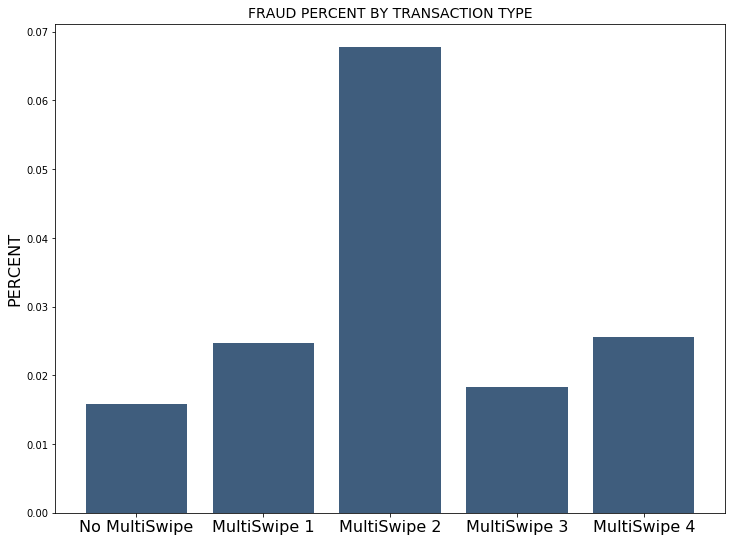

In [456]:

"""
There is a field indicating transaction reversals which happen after the inital transaction.

There were 20K transaction types with a reversal type code, and the total amount accounted for around 2.8M.
"""

type_view = df[['multiSwipeType','isFraud']].groupby('multiSwipeType').mean().reset_index()

fig = plt.figure(figsize=(12,9))
plt.bar(type_view.multiSwipeType.values.flatten(),
             type_view.isFraud.values.flatten(),color="#3F5D7D")
plt.title('FRAUD PERCENT BY TRANSACTION TYPE',fontsize=14)
plt.xticks([0,1,2,3,4],
           ['No MultiSwipe', 'MultiSwipe 1','MultiSwipe 2','MultiSwipe 3','MultiSwipe 4'],
           fontsize=16)
plt.ylabel('PERCENT',fontsize=16)
plt.show()

### Duplicate Transactions

Duplicate transaction can be multi-swipe or reversals. Multi-swipe transaction are described as when the vendor accidently charges the same transaction more than once. Reversals are described as a purchases followed by a reversals. It will be assumed that in order for the transaction to be considered duplicate, the transactions need to occur within 0-10 seconds of each other. 


### Multiswipe Transactions

It is implied by the definition for multi-swipe transaction that the vendor accidently charges the credit credit card multiple times for the same transaction amount. There were only 5 transaction that met the multi-swipe conditions that did not have the same transaction value.

Multi-swipe algorithm 1:
1. fuzzy inner join on the dataset
2. customerID+merchantName are the same
3. the transactions happen between 0 and 10 seconds apart
4. the rowIds are different
5. the transaction amounts are the **same**
6. the second transaction is a purchase

Multi-swipe algorithm 2:
1. fuzzy inner join on the dataset
2. customerID+merchantName are the same
3. the transactions happen between 0 and 10 seconds apart
4. the rowIds are different
5. the transaction amounts are **different**
6. the second transaction is a purchase

Multi-swipe algorithm 1:
1. fuzzy inner join on the dataset
2. customerID+merchantName are the same
3. the transactions happen between 0 and 10 seconds apart
4. the rowIds are different
5. the transaction amounts are the **same**
6. the second transaction is a reversal

Multi-swipe algorithm 2:
1. fuzzy inner join on the dataset
2. customerID+merchantName are the same
3. the transactions happen between 0 and 10 seconds apart
4. the rowIds are different
5. the transaction amounts are **different**
6. the second transaction is a reversal

### Notes

A multi-swipe can be fraud for one or many of the transactions.

Transaction types labelled as ADDRESS VERIFICATION or REVERSALS will not be not considered multi-swipe transaction. 

There are many transactions that happen within 0 seconds of each other, but not all of these are from the same customer and merchant.

### Additional Considerations

While this algorithm finds and join duplicate transactions, it doesn't effectively deal with multiple transaction. With more time, I would implement run this algorithm multiple times to deal with multi-transactions not just duplicates. In addition, reversals can potentially happend outside of the 10 second window, finding whether these are still considered duplicates, i.e. same amounts, or whether it is part of some other business process.

### Results

1. There were 405 multi-swipe transactions with the same transaction amount that resulted in an total amount of 60.5K.

2. There were 59 multi-swipe transactions with different transaction amounts that resulted in an total amount of 10.7K.

3. There were 328 reversal transactions with the same transaction amount that resulted in an total amount of 46.9K.

4. There were 39 reversal transactions with different transaction amounts that resulted in an total amount of 2.5K.

It was found that that multiswipe 2 carried a much higher risk for fraud with an average fraud value of 6.9%. This is much higher than the dataset's value of 1.5% fraud. The other multi-swipe transactions also carried slightly more risk that non-multiswipe transactions. Could be possible that these transactions are happening online and programmatically?

In [480]:
# df.to_pickle('df_20200228')
# df = pd.read_pickle('df_20200228')

dataset time window: 364 days 23:58:43


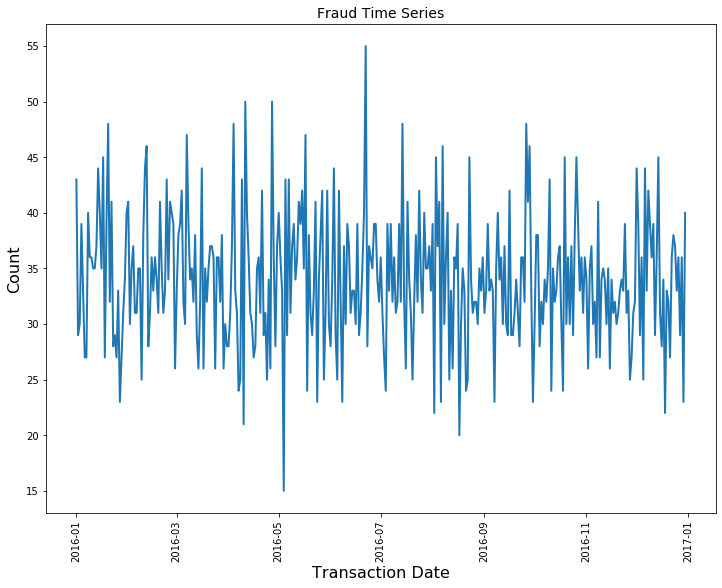

fraud mean 34.01917808219178 fraud deviation 5.9204585120516535 



In [520]:
"""
The dataset contains 1 year of data so any aggregate feature should use at most 6 months.

The number of fraud cases seems to be randomly distributed around 35 fraud cases per day +-10 cases.

Because the dataset contain a fair amount of class imbalance, the models' effectiveness will be based on
the number of false positives at 25, 35, and 45 true positives.

"""

print('dataset time window:',df.transactionDateTime.max()-df.transactionDateTime.min())


df['transactionDate'] = df.transactionDateTime.dt.date

plt.figure(figsize=(12,9))
plt.title('Fraud Time Series',fontsize=14)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Transaction Date',fontsize=16)
plt.xticks(rotation=90)
plt.plot(df[['transactionDate','isFraud']].groupby('transactionDate').sum(),linewidth=2)
plt.show()

fraud_mean_dy = df[['transactionDate','isFraud']].groupby('transactionDate').sum().mean().sum()
fraud_dev_dy = df[['transactionDate','isFraud']].groupby('transactionDate').sum().std().sum()

print('fraud mean',fraud_mean_dy,'fraud deviation',fraud_dev_dy,'\n')

Text(0.5, 0, 'Transaction DateTime')

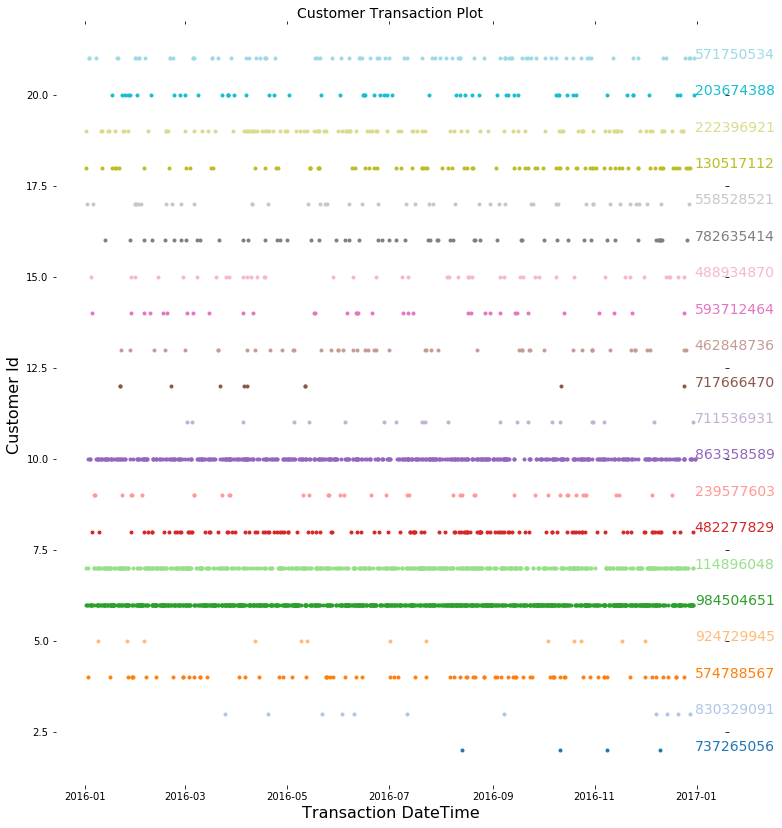

In [521]:
"""
Customer seem to take "breaks" from using their cards. Different customers have different break durations.

More time can be spent looking into individual purchase patterns.
"""

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

    
plt.figure(figsize=(12, 14))    
  
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")      
  
for rank, customer in enumerate(customers[:]):  
    

    cust_view = df.loc[df.customerId==customer,['customerId','transactionDateTime','rowId']]
    cust_view_gb = cust_view.groupby(['customerId','transactionDateTime']).count().reset_index()

    plt.plot(cust_view_gb.transactionDateTime.values,    
            cust_view_gb.rowId.values + rank+1, '.' ,color=tableau20[rank])    
  

    y_pos = cust_view_gb.rowId.values[-1] + rank+1
    plt.text(np.max(df.transactionDateTime), y_pos, customer, fontsize=14, color=tableau20[rank]) 

plt.title('Customer Transaction Plot',fontsize=14)
plt.ylabel('Customer Id',fontsize=16)
plt.xlabel('Transaction DateTime',fontsize=16)

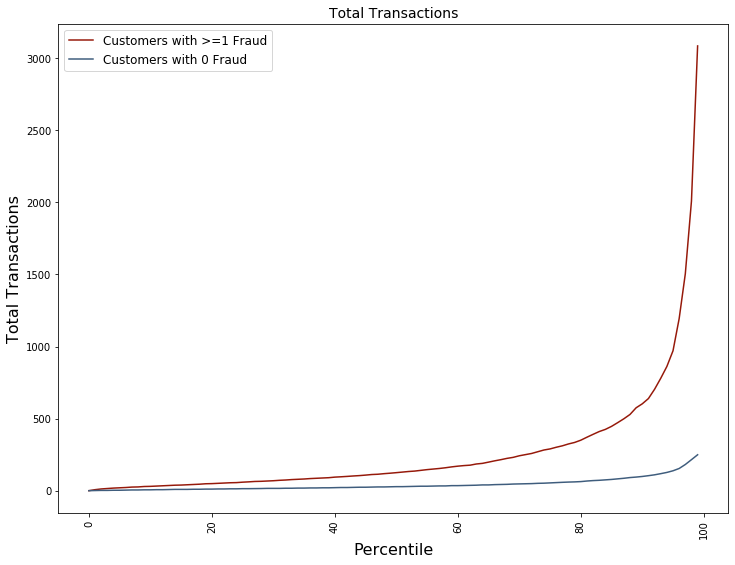

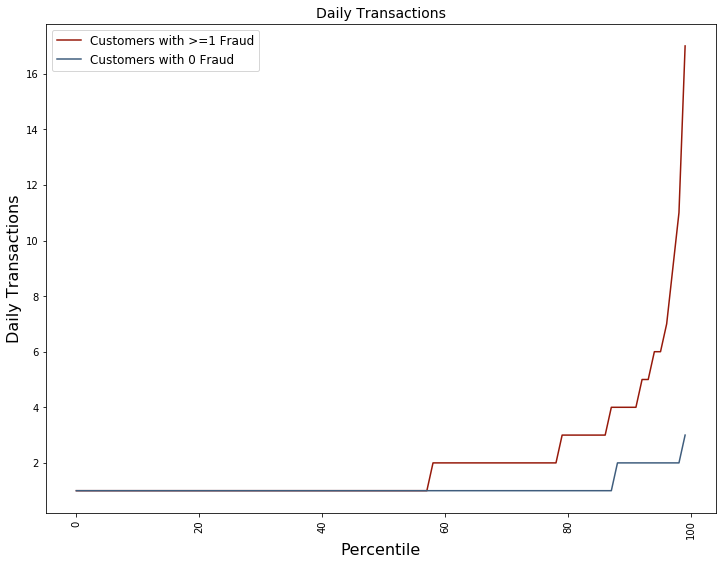

In [522]:

"""
The percentile plot of customer daily transaction count for customer with and without fraud were compared.

The customer total transactions percentile plot has a sharp increase at the 90th percentile.
90% of customers have less than 300 transactions per year.

Customers that have fraud also have a tendancy to make more transactions per day
"""

percentiles = np.arange(0,100)

plt.figure(figsize=(12,9))
plt.title('Total Transactions',fontsize=14)
plt.ylabel('Total Transactions',fontsize=16)
plt.xlabel('Percentile',fontsize=16)
plt.xticks(rotation=90)

cust_date_gb = df.loc[df.customerId.isin(df[df.isFraud==1].customerId),
        ['customerId','rowId']].groupby(['customerId']).count()
percent_vals = list(map(lambda x: np.percentile(cust_date_gb.values,x),percentiles))
plt.plot(percentiles,percent_vals,label='Customers with >=1 Fraud',color='#96190A')
cust_date_gb = df.loc[~df.customerId.isin(df[df.isFraud==1].customerId),
        ['customerId','rowId']].groupby(['customerId']).count()
percent_vals = list(map(lambda x: np.percentile(cust_date_gb.values,x),percentiles))
plt.plot(percentiles,percent_vals,label='Customers with 0 Fraud',color="#3F5D7D")
plt.legend(prop={'size': 12})
plt.show()


plt.figure(figsize=(12,9))
plt.title('Daily Transactions',fontsize=14)
plt.ylabel('Daily Transactions',fontsize=16)
plt.xlabel('Percentile',fontsize=16)
plt.xticks(rotation=90)

cust_date_gb = df.loc[df.customerId.isin(df[df.isFraud==1].customerId),
        ['customerId','transactionDate','rowId']].groupby(['customerId','transactionDate']).count()
percent_vals = list(map(lambda x: np.percentile(cust_date_gb.values,x),percentiles))
plt.plot(percentiles,percent_vals,label='Customers with >=1 Fraud',color='#96190A')
cust_date_gb = df.loc[~df.customerId.isin(df[df.isFraud==1].customerId),
        ['customerId','transactionDate','rowId']].groupby(['customerId','transactionDate']).count()
percent_vals = list(map(lambda x: np.percentile(cust_date_gb.values,x),percentiles))
plt.plot(percentiles,percent_vals,label='Customers with 0 Fraud',color="#3F5D7D")
plt.legend(prop={'size': 12})
plt.show()

In [10]:
df.reset_index(drop=True,inplace=True)
np.mean(df.index==df.rowId)

1.0

In [517]:
df.dtypes

accountNumber                               object
accountOpenDate                     datetime64[ns]
acqCountry                                  object
availableMoney                             float64
cardCVV                                     object
cardLast4Digits                             object
cardPresent                                   bool
creditLimit                                float64
currentBalance                             float64
currentExpDate                      datetime64[ns]
customerId                                  object
dateOfLastAddressChange             datetime64[ns]
enteredCVV                                  object
expirationDateKeyInMatch                      bool
isFraud                                       bool
merchantCategoryCode                        object
merchantCountryCode                         object
merchantName                                object
posConditionCode                            object
posEntryMode                   

In [ ]:

"""
There were 205 merchant names excluding the #HASH.

While merchantName is probably an effective feature, the feature may not be robust over time.

It might be more robust check if a customer has used this merchantId or companyName before. 

"""

def extract_company_name(x):
    pat = re.compile('\s\#\d+')
    return re.sub(pat,'',x)

df['companyNameOnly'] = df.merchantName.apply(lambda x: extract_merchant_name(x))

print('unique companies',df.companyNameOnly.nunique(),'merchant names',df.merchantName.nunique())

In [518]:
from sklearn import pipeline
from sklearn.base import BaseEstimator, TransformerMixin

"""
A cutomer label

This label encoder will assign missing values as a seperate label.

If these feature should be regularized heavily to produce robustness over time.

"""

class MultiColumnLabelEncoder(BaseEstimator,TransformerMixin):

    def __init__(self, columns=None):  
        self.columns = columns

    def fit(self, X, y=None):
        
        self.label_encoders = {}
        if self.columns is not None:
            for col in self.columns:
                enc = preprocessing.LabelEncoder()
                enc.fit(X[col])
                self.label_encoders[col] = enc
        return self

    def transform(self, X):
        
        output = pd.DataFrame()
        if self.columns is not None:
            for col in self.columns:
                output[col+'LabelEncoded'] = self.label_encoders[col].transform(X[col])

        return output

In [550]:
label_enc_cols = [
             'transactionType',
             'posEntryMode',
             'posConditionCode',
             'merchantCategoryCode',
             'companyNameOnly']

In [552]:
pipe = pipeline.Pipeline([
    ('labelize', MultiColumnLabelEncoder(columns=label_enc_cols)),
])

lenc = pipe.fit(df).transform(df)
#the labels are encoded correctly
print('qualit test',tmp[df['transactionType']==''].transactionTypeLabelEncoded.unique()==0)

for col in lenc:
    if col not in df.columns:
        print('adding',col)
        df = pd.concat([df,lenc[col]],axis=1)

qualit test [ True]
adding companyNameOnlyLabelEncoded


In [642]:
#https://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/
print('test',utils.levenshtein('hello','helpo'))
df['editDistanceCVV'] =df[['enteredCVV','cardCVV']].apply(
                                                    lambda x:utils.levenshtein(x['enteredCVV'],x['cardCVV'])
                                                    ,axis=1)


test 1.0


In [649]:
df['sameCountryInd']=df[['acqCountry','merchantCountryCode']].apply(
                                        lambda x: x['acqCountry']==x['merchantCountryCode']
                                        ,axis=1).astype(np.int)

df['percentOfCreditUsed'] = (df.availableMoney-df.creditLimit)/df.creditLimit

df['daysSinceAddressChange'] = (df.transactionDateTime-df.dateOfLastAddressChange).dt.days

df['daysSinceAccountOpen'] = (df.transactionDateTime-df.accountOpenDate).dt.days

df['cardPresent'] = df['cardPresent'].astype(np.int)

df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(np.int)

df['zeroAmount'] = (df.transactionAmount==0).astype(np.int)

df['transactionLogAmount'] = np.log(df.transactionAmount+1)

In [616]:
conn = utils.create_database('working')
cur = conn.cursor()
# conn.commit()


create_cols = [
 'customerId',
 'rowId',
 'transactionLogAmount',
 'multiSwipeType',
 'transactionType',
 'companyNameOnly',
 'merchantName',
 'merchantCategoryCode',
 'transactionDateTime',
 'cardLast4Digits']

cur.execute('''drop table if exists agg_table''')
df[create_cols].to_sql("agg_table", conn)

In [621]:
"""
A few aggregate features based on customerIds & transactionDateTime were created.

The features were kept simple for the purpose of completing this project in a timely manner.

More feature could be created using this approach to further describe customer purchases patterns.

1. The total number of transaction in the last 30 days
2. The minimum absolution transaction hour difference in the last 30 days
3. An indicator of whether the merchant catgory was previously used in the last 30 days
4. An indicator of whether the merchant name was previously used in the last 30 days
5. An indicator of whether the company name was previously used in the last 30 days
6. An indicator of whether the car number previously used in the last 30 days

"""

qry = """
select 
    a.rowId,
    count(1) transactionCount_30DY,
    avg(b.transactionLogAmount) avgLogTransactionAmount_30DY,
    min(abs(cast(strftime('%H',a.transactionDateTime) as integer)
        - cast(strftime('%H',b.transactionDateTime) as integer))) minAbsHourDiff_30DY,
    case when sum(b.merchantCategoryCode=a.merchantCategoryCode)>0 then 1 else 0 end previousMerchantCategory_30DY,
    case when sum(b.merchantName=a.merchantName)>0 then 1 else 0 end previousMerchantName_30DY,
    case when sum(b.companyNameOnly=a.companyNameOnly)>0 then 1 else 0 end previouscompanyNameOnly_30DY,
    case when sum(b.cardLast4Digits=a.cardLast4Digits)>0 then 1 else 0 end previousCardNumber_30DY
from agg_table a 
inner join agg_table b 
on a.customerId = b.customerId and 
    (julianday(a.transactionDateTime) - julianday(b.transactionDateTime)) <30 and
    (julianday(a.transactionDateTime) - julianday(b.transactionDateTime)) >=0 and
    a.rowId<>b.rowId
where b.multiSwipeType=0
group by 
a.customerId, a.transactionDateTime, a.rowId
"""

In [622]:

agg_tb = pd.read_sql(qry, conn)
agg_tb.head(100)

,rowId,transactionCount_30DY,avgLogTransactionAmount_30DY,minAbsHourDiff_30DY,previousMerchantCategory_30DY,previousMerchantName_30DY,previouscompanyNameOnly_30DY,previousCardNumber_30DY
0,541901,1,5.328507,19,0,0,0,1
1,541904,1,4.205737,15,0,0,0,1
2,541907,1,3.511545,5,0,0,0,0
3,541920,1,1.601406,20,0,0,0,1
4,541930,1,1.601406,12,0,0,0,1
5,541932,1,4.434500,11,0,0,0,0
6,541937,1,1.601406,3,0,0,0,0
7,541938,1,3.665867,15,1,0,0,0
8,541942,1,4.656813,4,1,0,0,0
9,541945,1,4.719391,2,0,0,0,0


In [ ]:
print('agg missing values:',df.shape[0]-df.merge(agg_tb, on=['rowId'], how='inner').shape[0])

In [9]:
df = df.merge(agg_tb, on=['rowId'], how='left')

"""
Fill the missing values.

I chose to fill the minimum absolute hour difference with 12, the middle between 0 and 24.
"""


df.minAbsHourDiff_30DY = df.minAbsHourDiff_30DY.fillna(12)
df.transactionCount_30DY = df.transactionCount_30DY.fillna(0)
df.avgLogTransactionAmount_30DY = df.avgLogTransactionAmount_30DY.fillna(0)
df.previousMerchantCategory_30DY = df.previousMerchantCategory_30DY.fillna(0)
df.previousMerchantName_30DY = df.previousMerchantName_30DY.fillna(0)
df.previouscompanyNameOnly_30DY = df.previouscompanyNameOnly_30DY.fillna(0)
df.previousCardNumber_30DY = df.previousCardNumber_30DY.fillna(0)

In [ ]:
conn.commit()
conn.close()

In [14]:
df.to_pickle('df_final.pkl')

In [2]:
"""
Feature sets - these lists categorize the variables on different aspects
"""

transaction_features = [
                        'cardPresent',
                        'expirationDateKeyInMatch',
                        'zeroAmount',
                        'multiSwipeType',
                        'daysSinceAccountOpen',
                        'daysSinceAddressChange',
                        'sameCountryInd',
                        'editDistanceCVV',
                        'transactionTypeLabelEncoded',
                        'posEntryModeLabelEncoded',
                        'posConditionCodeLabelEncoded',
                        'merchantCategoryCodeLabelEncoded']

customer_features = [
                    'transactionLogAmount',
                    'percentOfCreditUsed',
                    'minAbsHourDiff_30DY',
                    'transactionCount_30DY',
                    'avgLogTransactionAmount_30DY',
                    'previousMerchantCategory_30DY',
                    'previousMerchantName_30DY',
                    'previouscompanyNameOnly_30DY',
                    'previousCardNumber_30DY']

numeric_cols = [
                'cardPresent',
                'expirationDateKeyInMatch',
                'zeroAmount',
                'daysSinceAccountOpen',
                'daysSinceAddressChange',
                'sameCountryInd',
                'editDistanceCVV',
                'transactionLogAmount',
                'percentOfCreditUsed',
                'minAbsHourDiff_30DY',
                'transactionCount_30DY',
                'avgLogTransactionAmount_30DY',
                'previousMerchantCategory_30DY',
                'previousMerchantName_30DY',
                'previouscompanyNameOnly_30DY',
                'previousCardNumber_30DY']

cat_cols = ['multiSwipeType',
            'transactionTypeLabelEncoded',
            'posEntryModeLabelEncoded',
            'posConditionCodeLabelEncoded',
            'merchantCategoryCodeLabelEncoded',
              ]



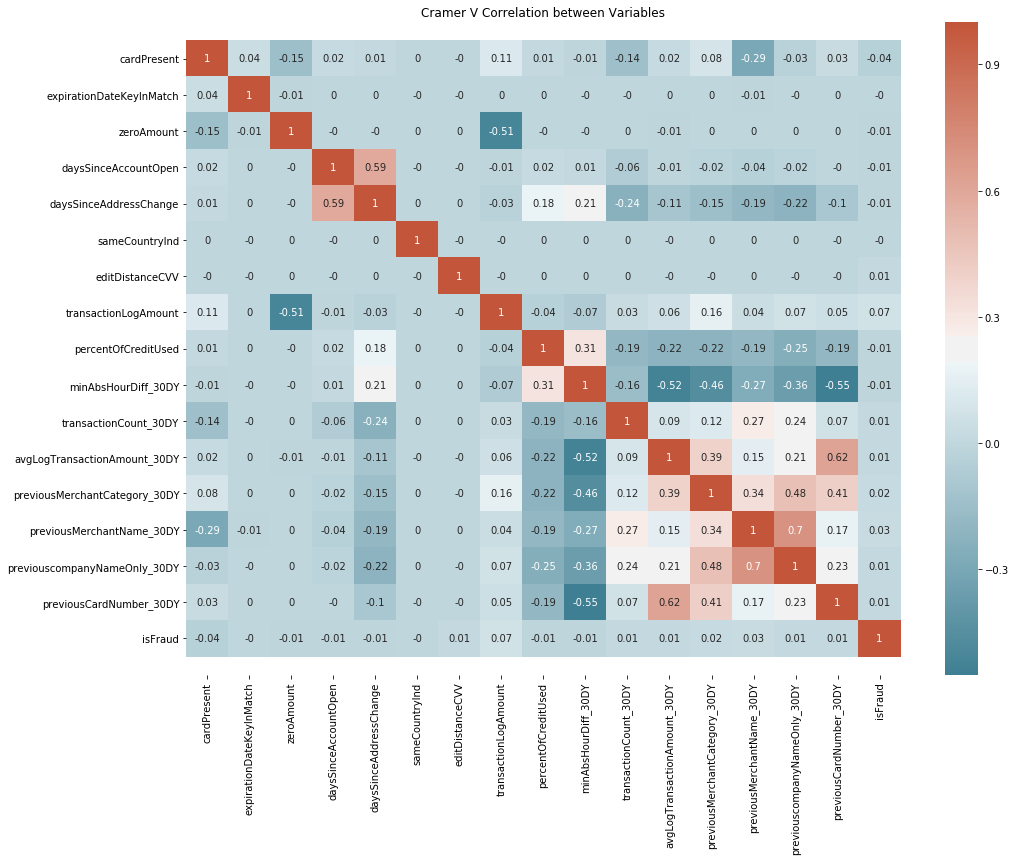

In [13]:
"""
It was unexpected to see the customer variables be correlated to the target variable.

"""

importlib.reload(utils)
plt.figure(figsize=(16,12))
plt.title("Cramer V Correlation between Variables")
utils.plot_pearson_corr_heatmap(df,numeric_cols+['isFraud'])

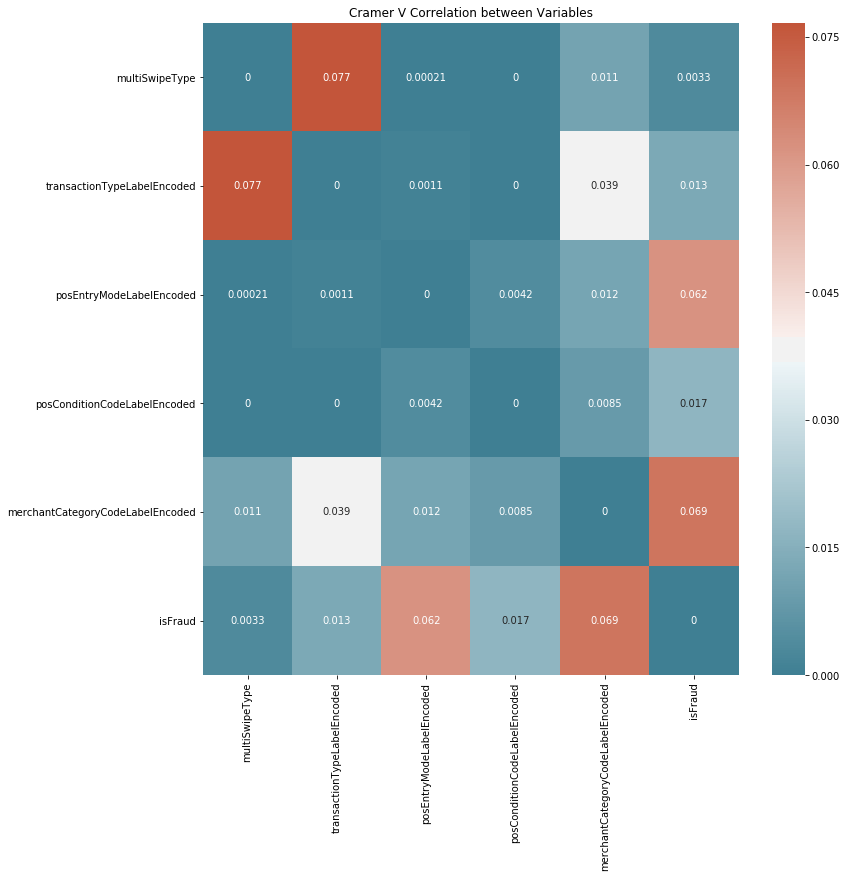

In [8]:
"""The categorical variables produce very low correlations, however there may be interactions"""

importlib.reload(utils)

"""
Cramer's V can be used to correlate categorial variables
"""

#cramers-v https://www.kaggle.com/aleksandradeis/nfl-injury-analysis
plt.figure(figsize=(12,12))
plt.title("Cramer V Correlation between Variables")
utils.plot_cramers_v_heatmap(df[cat_cols+['isFraud']]
                       ,cols=cat_cols+['isFraud'])




In [15]:
df = pd.read_pickle('df_final.pkl')

In [29]:
"""
Here are some basic dataset metrics used to downsample 
and to calculate the average fraud cases per day for each cross-validated split
"""

min_class_count = df['isFraud'].value_counts().min()
max_class_count = df['isFraud'].value_counts().max()

print('idFraud=1 is ',100*min_class_count/max_class_count,'% of isFraud=0')

print('average expected fraud cases in each validation spit',df.isFraud.sum()/5)
print('average estimated days in each validation spit',364/5)

idFraud=1 is  1.6043754990658263 % of isFraud=0
average expected fraud cases in each validation spit 2483.4
average estimated days in each validation spit 72.8


In [17]:
from sklearn import metrics

importlib.reload(utils)


def find_thres_30_per_dy(ypred,ytrue):
    thrshld = 0
    rows = 786363
    #estimate the days the sample by (sample size)/rows
    days = int(364*(ypred.shape[0]/rows))
    for i in np.linspace(1,0,1000):
        tp,fp,tn,fn,acc = utils.classification_metrics(ypred>i,ytrue.flatten())
        if tp>30*days:
            print('stopped at',int(tp/days),'true positives per day')
            thrshld=i
            break
    return thrshld

def custom_metric(ypred,ytrue):
    thrshld = find_thres_30_per_dy(ypred,ytrue)
    tp,fp,tn,fn,acc = utils.classification_metrics(ypred>thrshld,ytrue.flatten())
    return tp/fp


def model_evaluation(model,data:dict,args:dict):
    
    rslt = {}
    
    model = model.set_params(**args)
    
    kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True)

    models=[]
    avg_fp_cv_custom_metric=[]
    avg_cv_score=[]
    for train_index, val_index in kf.split(data['X'],data['y']):
        
        #train val split
        cv_train_x = data['X'].iloc[train_index].values
        cv_val_x = data['X'].iloc[val_index].values
        cv_train_y = data['y'].iloc[train_index].values
        cv_val_y = data['y'].iloc[val_index].values

        #smart downsampling +0.1% to avoid undersampling
        down_sample_train = (cv_train_y.flatten()==0)&(np.random.uniform(0,1,size=cv_train_x.shape[0])<0.017)
        down_sample_train = down_sample_train|(cv_train_y.flatten()==1)
        
        down_sample_val = (cv_val_y.flatten()==0)&(np.random.uniform(0,1,size=cv_val_x.shape[0])<0.017)
        down_sample_val = down_sample_val|(cv_val_y.flatten()==1)
        
        model.fit(cv_train_x[down_sample_train],cv_train_y[down_sample_train],
                 eval_set=(cv_val_x[down_sample_val],cv_val_y[down_sample_val]))
        
        #model eval
        score = model.score(cv_val_x,cv_val_y)
        cv_val_y_pred = model.predict_proba(cv_val_x)[:,1]
        avg_fp_cv_custom_metric.append(custom_metric(cv_val_y_pred,cv_val_y))
        avg_cv_score.append(metrics.roc_auc_score(y_true=cv_val_y,y_score=cv_val_y_pred))
        models.append(model)
        
    print('avg_fp_cv_custom_metric',avg_fp_cv_custom_metric)
    print('avg_cv_score',avg_cv_score)
    print()

    rslt['avg_cv_score'] = avg_cv_score
    rslt['avg_cv_custom_metric'] = avg_fp_cv_custom_metric
    
    rslt['model'] = models

    return rslt

In [7]:
"""
This code correctly encodes all the categorical variables.

The dataset is stored into a dictionary for further processing.

"""

all_columns = transaction_features+customer_features
cat_mask = np.array([i for i,col in enumerate(all_columns) if col in cat_cols]).astype(np.int)
for col in cat_cols:
    df[col] = df[col].astype('category')
data = {'X':df[all_columns],'y':df[['isFraud']].astype(np.int)}
df[cat_cols].dtypes

multiSwipeType                      category
transactionTypeLabelEncoded         category
posEntryModeLabelEncoded            category
posConditionCodeLabelEncoded        category
merchantCategoryCodeLabelEncoded    category
dtype: object

In [8]:
"""
Define various parameter selection (4) total models were tested
"""

param_choices = { 
    'depth': [6, 8],
    'learning_rate': [0.03],
    'random_strength': [0.1],
    'bagging_temperature': [1.0],
    'border_count': [254],
    'l2_leaf_reg': [3., 10.]
}

default_values = [{'depth':6,
'learning_rate':0.03,
'random_strength':1,
'bagging_temperature':1,
'border_count':254,
'l2_leaf_reg':3.0}]

param_grid = list(model_selection.ParameterGrid(param_choices))
# param_grid = default_values+param_grid
print(len(param_grid))

4


In [14]:
import time

start_time = time.time()

#https://www.kaggle.com/lsinev/catboost-with-bayes-opt/comments#744727

leaderboard = []
for args in param_grid:
    
    model = catboost.CatBoostClassifier(
                         thread_count=4,
                         loss_function='Logloss',
                         cat_features=cat_mask,
                         early_stopping_rounds=300,
                         iterations=1000,
                         eval_metric='AUC',
                         use_best_model=True,
                         verbose=False)
    
    rslt = model_evaluation(model,data,args)
    rslt['args'] = args
    leaderboard.append(rslt)
    
end_time = time.time()

print('elapsed time', end_time-start_time,'seconds')

stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true positives per day
avg_fp_cv_custom_metric [0.028069537670565935, 0.028449558314353796, 0.028698421122462518, 0.029320380445843452, 0.02731604960119326]
avg_cv_score [0.7854408637789767, 0.7890009306627778, 0.790119941040808, 0.793131476989344, 0.7800398998195059]

stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true positives per day
avg_fp_cv_custom_metric [0.02868177957103419, 0.028708833180556108, 0.027434459305129052, 0.027768144980027998, 0.029555774385907327]
avg_cv_score [0.7887489403075737, 0.7918916248662183, 0.7858052240977296, 0.7854724545752247, 0.7954582852080032]

stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true positives per day
stopped at 30 true posi

In [20]:
for rslt in leaderboard:
    print(rslt['args'])
    print('AUC metric',np.mean(rslt['avg_cv_score']))
    print('custom metric',np.mean(rslt['avg_cv_custom_metric']))
    print()

{'bagging_temperature': 1.0, 'border_count': 254, 'depth': 6, 'l2_leaf_reg': 3.0, 'learning_rate': 0.03, 'random_strength': 0.1}
AUC metric 0.7875466224582823
custom metric 0.02837078943088379

{'bagging_temperature': 1.0, 'border_count': 254, 'depth': 6, 'l2_leaf_reg': 10.0, 'learning_rate': 0.03, 'random_strength': 0.1}
AUC metric 0.7894753058109499
custom metric 0.02842979828453094

{'bagging_temperature': 1.0, 'border_count': 254, 'depth': 8, 'l2_leaf_reg': 3.0, 'learning_rate': 0.03, 'random_strength': 0.1}
AUC metric 0.7893718130713807
custom metric 0.028491115633011554

{'bagging_temperature': 1.0, 'border_count': 254, 'depth': 8, 'l2_leaf_reg': 10.0, 'learning_rate': 0.03, 'random_strength': 0.1}
AUC metric 0.7905702202985669
custom metric 0.028578225849315055



In [21]:
"""
Get the best model from the leaderboard
"""
best_model = leaderboard[3]['model'][0]

best_model.save_model('best_catboost_model')

ypred = best_model.predict_proba(data['X'].values)[:,1]

In [23]:
"""
The threshold was select for where most of the fraud cases are captured per day.
"""

thrshld = find_thres_30_per_dy(ypred,data['y'].values)


stopped at 30 true positives per day
0.3943943943943944


In [26]:
tp,fp,tn,fn,acc = utils.classification_metrics(ypred>thrshld,data['y'].values.flatten())
print(tp,fp,tn,fn,acc,thrshld)
print('probability threshold ',thrshld)
print('accuracy ',acc)
print(tp/(tp+fn),'of the positives were captured')
print(tn/(fp+tn),'of the negatives were excluded')


10928 309623 464323 1489 0.604365922608261 0.3943943943943944
probability threshold  0.3943943943943944
accuracy  0.604365922608261
0.8800837561407747 of the positives were captured
0.5999423732405104 of the negatives were excluded


Text(0.5, 0, '')

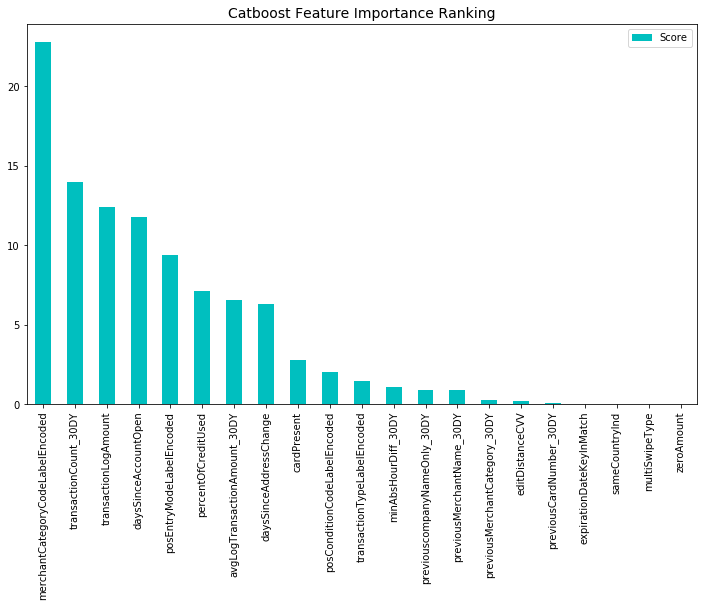

In [27]:
feature_score = pd.DataFrame(list(zip(data['X'].dtypes.index, 
                                     best_model.get_feature_importance(
                                         catboost.Pool(data['X'].values, label=data['y'].values,
                                                                       cat_features=cat_mask)))
                                     ),columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score',
                                          ascending=False,
                                          inplace=False,
                                          kind='quicksort',
                                          na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

### Data Exploration

It is unknown whether a sample of customers or transactions were collected. Creating a sequence of purchase patterns might not be applicable if the transactions were already sampled from another database. 

Various plots were used to determine the sampling methodology used in the dataset. A plot of fraud over by date showed that the number of fraud cases per day stays relatively close to 35 +- 10 cases.

A chart of transactions over time for a sample of 20 customers was also created. It showed a consistent transaction pattern with periodic breaks. This is possibly evidence that all transactions were collected within this 1 year time frame.

A percentile plot of total transaction and daily transaction across customers was also created. These plots showed that customers that had at least 1 case of fraud had a tendency to make more total transactions (in 1 year) and more daily transactions.

How were the customers chosen to be included in the dataset?


### Data Engineering

There are some constrains on the dataset and the objective. We only have a sample for 1 year of data. This data has already been down sampled and probably contain some bias. The objective of predicting fraud with 12417 cases will probably be enough to generalize risk, but outliers and anomalies might need to be removed to improve the model's performance.

How is the isFraud assigned? Knowing whether isFraud is available could make it viable as a feature. For example, are customer's with previous fraud more likely to have another case of fraud? Is a card number that has had prior fraud more likely to have another case of fraud? These featues were excluded due to the process being unknown.

**Feature engineering was split into two different types of features: 1) transactional features 2) customer features.**

1. Transactional features are in relation to the current transaction, i.e., is the card expired, how close was the entered CVV to the actual CVV, how many days between the transaction to an address change, etc.

2. Customer related features are in relation to an account, i.e., has customer used this company or particular merchant in the last 30 days, has this customer used this card in the last 30 days, what was the average transaction amount in the last 30 days, etc.

The only excluded feature was the customer's current balance, and it was excluded because the objective is to indentify fraud not credit risk. The effectiveness of this feature could be tested later.

### ML Pipeline

How the model will be used is unknown, i.e., decision support, automated flagging, research and development, etc. The model will predict whether a particular customer, card number, and transaction will be a fraud case. 

Ideally, the model will be used to automatically flag potential fraud cases. The cost of a false positive (predicting fraud when it is not) is much less than a false negative (not predicting fraud when it is). The model's effectiveness will be based on the model's ability to indentify most of the fraud cases. A custom metric was designed to choose the best model.

custom metric: **(true positives)/(false positives) where true positives>30 per day (average)**

The reasoning behind using this metric is that it shows which model effectively detects most fraud cases and segments the data from the most likely non-fraud cases. Additional models could be overlayed to this baseline model.

The goal of this modeling cycle was to develop a baseline model, determine the most important features, and theorize additional improvement that can be made.

Modeling pipeline:
1. Choose model type
2. Develop a search set of tuning hyperparameters
3. Use stratified K-fold to create 5 training and validation splits
4. Use smart downsampling on non-fraud cases
5. Optimize the model using log-loss
6. Define early stopping to be AUC on the validation
7. Compute model on custom metric
8. Save to leaderboard of models

A total of 4 cross-validated catboost models were assessed with various hyperparameters. The metrics were calcuated on the validation dataset for each model. After the stratified k-fold split, the data was downsampled to balance the positive and negative classes for training. This helps the model distinguish the objective of modeling fraud cases from labeling non-fraud cases.

The decision to use catboost was mostly due to its efficiency and easy of use. If I had more time, I would explore using neural network approaches (tensorflow) and utilize anomaly detection methods. Specifically, I would be interested in building a deep neural network to model/characterize the purchase patterns of the customer's in the dataset. This could potentially helpful as a semi-supervised approach to dig into individual cases. 

The best model was chosen based on the model's effectiveness at the probability threshold where most of the fraud cases were captured, i.e, 30 fraud cases per day.

If I had more time to work on this problem, additional hyper-parameter tuning and different models would be built. For example, at the bottom of this notebook, a one-hot encoding, perceptron network was built using tensorflow. In the interest of time, this model was not run.


### Results



The best model was saved as a binary file called: best_catboost_model

Average Metrics for Cross-Validation:
1. Average AUC for the best model on validation: 0.7905702202985669
2. Best TP/FP for 30 TP a day: 0.028578225849315055

The AUC metrics can be interpreted at the model performance above random. I chose the custom metric to determine the effeciency of the model where most of the fraud cases were capture. It turned out that the model with the best AUC also had the best custom metric.

**Note: the AUC metric was compute on the unbalanced validation set**

Operational Performance (calculated on all data):
1. Probability threshold  0.3943943943943944
2. Accuracy  0.604365922608261
3. 88% of the positives were captured
4. 60% of the negatives were excluded

The probability threshold was select for where 30 fraud cases were detected per day, where the average fraud cases per day is 35 +- 10 cases. If this model were to be put into production, it would incorrectly flag 40% of all transactions of fraud, but it would correctly flag 88% of fraud cases. 

The feature importance was ranked as follows:
0. merchantCategoryCodeLabelEncoded
1. transactionCount_30DY
2. transactionLogAmount
3. daysSinceAccountOpen
4. posEntryModeLabelEncoded
5. percentOfCreditUsed
6. avgLogTransactionAmount_30DY
7. daysSinceAddressChange
8. cardPresent
9. posConditionCodeLabelEncoded
10. transactionTypeLabelEncoded
11. minAbsHourDiff_30DY
12. previouscompanyNameOnly_30DY
13. previousMerchantName_30DY
14. previousMerchantCategory_30DY
15. editDistanceCVV
16. previousCardNumber_30DY
17. expirationDateKeyInMatch
18. sameCountryInd
19. multiSwipeType
20. zeroAmount

The top feature was the merchant category code which shows a potential bias in the data for a particular type of fraud. The best feature from the customer-aggregate features turned out to be the number of non-multiswipe transaction in the last 30days for a customer (ranked 2). A larger time window might have improved the effectiveness of the customer aggregate variables. Also, a linear model would have probably used these aggregate feature in a more effective fashion.



### Additional Work

In [ ]:
"""
#one-hot encoding perceptron network
class MultihotEmbedding(layers.Layer):

    def __init__(self, vocab_size, **kwargs):
        self.vocab_size = vocab_size
        super(MultihotEmbedding, self).__init__(**kwargs)

    def call(self, x):
        self.get_embeddings = K.one_hot(x,num_classes=self.vocab_size)
        self.reduce_embeddings = K.sum(self.get_embeddings,axis = -2)
        return self.reduce_embeddings

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.vocab_size)
    
cat_N = len(cat_cols)
num_N = len(numeric_cols)
    
for col in cat_cols:
    df[col] = df[col].astype(np.int64)
    
import tensorflow as tf

cat_inputs = []
embed_layers = []
for i in range(df[cat_cols].shape[1]):
    print(i)
    inp = tf.keras.layers.Input(shape=(1,))
    
    n_uniq = np.max(df[cat_cols].values[:,i]).astype(np.int)
    
    layer = MultihotEmbedding(n_uniq)(inp)
    
    cat_inputs.append(inp)
    embed_layers.append(layer)
    

one_hot_layer = tf.keras.layers.Concatenate()(embed_layers)
num_input = tf.keras.Input(shape=(num_N))


output = tf.keras.layers.Dense(2, activation="softmax")(e)

model = tf.keras.Model(cat_inputs+[num_input], output)


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy',tf.keras.metrics.AUC()])

kf = model_selection.StratifiedKFold(n_splits=2,shuffle=True)


for train_index, val_index in kf.split(data['X'],data['y']):
    cv_train_x = data['X'].iloc[train_index]
    cv_val_x = data['X'].iloc[val_index]
    cv_train_y = data['y'].iloc[train_index]
    cv_val_y = data['y'].iloc[val_index]

    XTRAIN = [cv_train_x[[col]].values for col in cat_cols]
    XVAL = [cv_val_x[[col]].values for col in cat_cols]
    
    XTRAIN+=[cv_train_x[numeric_cols].values]
    XVAL+=[cv_val_x[numeric_cols].values]
    
    YTRAIN = cv_train_y.values
    YVAL = cv_val_y.values
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.0001, patience=5,
                                     verbose=1, mode='max', baseline=None, restore_best_weights=True)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                          patience=3, min_lr=1e-3, mode='max', verbose=1)


    model.fit(XTRAIN,
                  YTRAIN,
                  validation_data=(XVAL, YVAL),
                  verbose=1,
                  batch_size=256,
                  callbacks=[es, rlr],
                  epochs=100,
                 )

ypred = model.predict(XTEST, batch_size=100,workers=6)

model.fit(cv_train_x,cv_train_y,
         eval_set=(cv_val_x,cv_val_y))
score = model.score(cv_val_x,cv_val_y)
cv_val_y_pred = model.predict_proba(cv_val_x)[:,1]
print('custom metric',custom_metric(ypred,YVAL))
print('auc',metrics.roc_auc_score(y_true=YVAL,y_score=ypred))
"""

### What are the POS variables?

#### POS Entry Codes - his field contains a code identifying transaction conditions at the point-of-sale or point-of-service. For messages that follow an original request, this code identifies the type of processing being done. The following table lists POS condition codes:

1. 02 - Magnetic stripe read. For Plus transactions, this code also means that the exact Track 2 content is included and CVV checking is possible.
2. 05 - Integrated circuit card read; card data reliable.
3. 09 - PAN entry via electronic commerce, including chip.
4. 80 - Chip card was unable to process/magnetic stripe read default.
5. 90 - Magnetic stripe read and extract content of Track 1 or Track 2 included (CVV check is possible).

#### POS Condition Code - This two-digit code identifies the actual method used to enter the cardholder account number and card expiration date. This code specifies whether the entire magnetic stripe is included in an authorization request:

1. 00 - Normal transaction of this type
2. 01 - Cardholder not present
3. 02 - Unattended terminal, customer operated (for example, an Automated Dispensing Machine)
4. 08 - Mail/telephone order (includes Visa phone and reoccurring transactions)